In [24]:
import numpy as np
import torch as tc
from torch.autograd import Variable
import matplotlib.pyplot as plt
import inspect

## 1.4 Linear regression in the PyTorch way



PyTorch Rhythm:
    1. Design your model using `class` with `Variable`
    2. Construct loss and optimizer
    3. Training cycle
        (forward, backward, update)

### 1.4.1 Design your model using `class` with `Variable`

To design a **linear regression model** with PyTorch, we'll use a predefined function called **`tc.nn.Linear`.** `tc.nn.Linear` receives a Variable, and makes a prediction with a random weight. For example, we can construct a linear regression model with **one input and one output.**

In [60]:
print(tc.nn.Linear.__doc__)

Applies a linear transformation to the incoming data: :math:`y = Ax + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, in\_features)` where `*` means any number of
          additional dimensions
        - Output: :math:`(N, *, out\_features)` where all but the last dimension
          are the same shape as the input.

    Attributes:
        weight: the learnable weights of the module of shape
            (out_features x in_features)
        bias:   the learnable bias of the module of shape (out_features)

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = autograd.Variable(torch.randn(128, 20))
        >>> output = m(input)
        >>> print(output.size())
    


In [18]:
tc.nn.Linear(1,1)(Variable(tc.Tensor([[1.0], [2.0], [3.0]]))) # (1,1): one input and one output

Variable containing:
 1.1464
 2.0271
 2.9079
[torch.FloatTensor of size 3x1]

In [19]:
tc.nn.Linear.__repr__(tc.nn.Linear(1,1))

'Linear(in_features=1, out_features=1)'

You can get the (weight) parameter of `tc.nn.Linear` by using `.parameters()` (which is from a class `nn.Parameter`).

In [20]:
print(inspect.getsource(tc.nn.Parameter))

class Parameter(Variable):
    r"""A kind of Variable that is to be considered a module parameter.

    Parameters are :class:`~torch.autograd.Variable` subclasses, that have a
    very special property when used with :class:`Module` s - when they're
    assigned as Module attributes they are automatically added to the list of
    its parameters, and will appear e.g. in :meth:`~Module.parameters` iterator.
    Assigning a Variable doesn't have such effect. This is because one might
    want to cache some temporary state, like last hidden state of the RNN, in
    the model. If there was no such class as :class:`Parameter`, these
    temporaries would get registered too.

    Another difference is that parameters can't be volatile and that they
    require gradient by default.

    Arguments:
        data (Tensor): parameter tensor.
        requires_grad (bool, optional): if the parameter requires gradient. See
            :ref:`excluding-subgraphs` for more details.
    """
    def __ne

In [21]:
list(tc.nn.Linear(1,1).parameters())

[Parameter containing:
  0.5686
 [torch.FloatTensor of size 1x1], Parameter containing:
  0.8710
 [torch.FloatTensor of size 1]]

Also, when you make a model, you'll make the model as a **subclass of `tc.nn.Module` to use all the functions therein.** Therefore, you need to put `tc.nn.Module` as an object of Model class by using `super`:

`Model(tc.nn.Module):
    def __init(self):
        super(Model, self).__init__()`

In [50]:
import torch as tc
from  torch.autograd import Variable

x_data = Variable(tc.Tensor([[1.0], [2.0], [3.0]])) # Define 3X1 dataset (matrix).
y_data = Variable(tc.Tensor([[2.0], [4.0], [6.0]])) # Define 3X1 dataset (matrix).

class Model(tc.nn.Module): # create class Model, which is a subclass of torch.nn.Module
    def __init__(self): #Initialize class: Codes to be executed when the object is created
        super(Model, self).__init__() #super lets the class call the parent classes (torch.nn.Module in this case) before all the codes below are executed.
        # You can do some initalization task, or create some element and components for neural net.
        self.linear = tc.nn.Linear(1, 1) # Linear model block: Input_size (1), Output_size (1)
        
    def forward(self, x): # one input (x)
        # We don't use our own weight `w`, but we use the block we initialized in line 11.
        y_pred = self.linear(x)
        return y_pred
            
#Once created a class, you can create an instance using the class
model = Model()

In [34]:
model.forward(x_data)

Variable containing:
 0.1107
 0.2255
 0.3403
[torch.FloatTensor of size 3x1]

### 1.4.2 Construct loss (or select loss from the api) and optimizer

Now we will calculate loss and do optimization. In order to to optimization, **you need to be able to use model parameter, which you can get by using `model.parameters()` (which is from a class `nn.Parameter`).**

`nn.Parameter` class is a very very simple subclass of `Variable`, but it has a special behaviour when assigned as a module attribute - it gets added to the parameter list, and is returned when you call model.parameters(). Variables aren’t added automatically, we thought of many cases where you’d want to cache some Variable in your model, without adding them to parameters (e.g. when writing an recurrent network you might want to save the last hidden state so you don’t have to pass it over and over).

Also Parameters are convenient, because **they `require_grad` by default.**

In [174]:
list(tc.nn.Linear(3,1).parameters())

[Parameter containing:
  0.1892  0.1998  0.5011
 [torch.FloatTensor of size 1x3], Parameter containing:
 -0.5761
 [torch.FloatTensor of size 1]]

In [171]:
list(model.parameters())

[Parameter containing:
 1.00000e-02 *
  -9.5706
 [torch.FloatTensor of size 1x1], Parameter containing:
 -0.8476
 [torch.FloatTensor of size 1]]

First element `list(model.parameters())[0]` corresponds to the input (and the size is the same as the input size), and the second element `list(model.parameters())[1]` corresponds to the output (and the size is the same as the output size).

In [51]:
# We use MSE Loss
criterion = tc.nn.MSELoss(size_average = False)
                         
# We use SGD. We need to pass what parameter / variable we are updating
# In this case, we update model variable using model.parameters()
optimizer = tc.optim.SGD(model.parameters(), lr = 0.01)

### 1.4.3 Training cycle: Forward, loss, backward, update

In [52]:
for epoch in range(100):
    # Predict Y by passing every elements of x (input whole x matrix)
    y_pred = model.forward(x_data)
#     print(x_data)
#     print(y_pred)
    
    #Compute loss: compare between predictive value and real value
    loss = criterion(y_pred, x_data)
    print(epoch, loss.data[0])
    
    #Backward pass
    #3.1. Before we compute gradients, we initialize all gradients.
    optimizer.zero_grad()
    #3.2 Compute all gradients with respect to ALL VARIABLES
    loss.backward()
    #3.3 UPDATE variable. What variables? model.parameters().
    optimizer.step()

0 9.049306869506836
1 4.050587177276611
2 1.8249815702438354
3 0.8338918685913086
4 0.39237838983535767
5 0.19552509486675262
6 0.10759192705154419
7 0.06815139949321747
8 0.05030248314142227
9 0.04206973686814308
10 0.03812200203537941
11 0.0360858254134655
12 0.03490469977259636
13 0.03410810977220535
14 0.033486586064100266
15 0.032946910709142685
16 0.03244740515947342
17 0.03196948766708374
18 0.03150486573576927
19 0.03104979544878006
20 0.03060251660645008
21 0.030162280425429344
22 0.02972857840359211
23 0.029301246628165245
24 0.02888011746108532
25 0.028465040028095245
26 0.028055943548679352
27 0.027652747929096222
28 0.027255330234766006
29 0.026863649487495422
30 0.026477541774511337
31 0.02609703503549099
32 0.0257219597697258
33 0.025352314114570618
34 0.024987956508994102
35 0.02462884411215782
36 0.024274900555610657
37 0.023926017805933952
38 0.023582151159644127
39 0.023243235424160957
40 0.022909199818968773
41 0.022579971700906754
42 0.0222554299980402
43 0.0219356

In [137]:
import torch as tc
from torch.autograd import Variable

class Model(tc.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = tc.nn.Linear(1,1)
        
    # YOU NEED TO NAME IT AS FORWARD.
    def forward(self, x):
        return self.linear(x)
    
model = Model()

x_data = Variable(tc.Tensor([[1.0], [2.0], [3.0]]))
y_data = Variable(tc.Tensor([[2.0], [4.0], [6.0]]))

criterion = tc.nn.MSELoss(size_average=False)
optimizer = tc.optim.SGD(model.parameters(), lr=0.01)
# Best option: optimizer = tc.optim.Rprop(model.parameters(), lr=0.01)

for epoch in range(1000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    

print(model.forward(x_data))

Variable containing:
 2.0004
 4.0001
 5.9998
[torch.FloatTensor of size 3x1]



In [116]:
y_pred.data


 2.0004
 4.0001
 5.9998
[torch.FloatTensor of size 3x1]

# 1.5 Logistic regression

for **Binary prediction.** (Logistic regression is a **classification algorithm.**

How to turn our model to predict 0 & 1 instead of real numbers? You can use **sigmoid function.** Sigmoid function **squashes real numbers between 0 and 1.**

Therefore, if you want to turn real-valued function to binary (0 and 1), you can wrap the real-valued function with sigmoid:

<center>$\hat{y} = \sigma(xw + b)$</center>
where
<center>$\sigma(x)=\frac{1}{e^{-x} + 1}$</center>

Also, you need to use **cross entropy loss** instead of maximum square estimate (MSE), because MSE does not work well for sigmoid function.

<center>$\text{loss} = -\frac{1}{N}\sum_{n=1}^{N} y_n \log(\hat{y_n}) + (1-y_n)\log(1-\hat{y_n}) $</center>

For binary-decision making, you set a threshold (cutoff value) that determines binary decision. The output of sigmoid function is between 0 and 1, and **it is common in the binary decision making that you consider the decision to be 1 if the output of sigmoid is larger than 0.5.** You can use different threshold, but then you need to be careful to decide the right threshold. About choosing the correct threshold, see

1. <http://ethen8181.github.io/machine-learning/unbalanced/unbalanced.html>
2. [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [347]:
import torch as tc
from torch.autograd import Variable


x_data = Variable(tc.Tensor([[1.0], [2.0], [3.0], [4.0]]))
y_data = Variable(tc.Tensor([[0.0], [0.0], [1.0], [1.0]]))

class Model(tc.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.linear = tc.nn.Linear(1,1)
    
    def forward(self, x):
        # wrap linear output with sigmoid function.
        y_pred = tc.nn.functional.sigmoid(self.linear(x))
        return y_pred


model = Model()
# Binary cross-entropy loss
criterion = tc.nn.BCELoss(size_average=True)
optimizer = tc.optim.SGD(model.parameters(), lr = 0.01)

for epoch in range(1000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [348]:
print(loss.data[0])
model(Variable(tc.Tensor([[4.0]])))

0.4705265462398529


Variable containing:
 0.8106
[torch.FloatTensor of size 1x1]

You can use different activation functions: `ReLU`, `SELU`, `Threshold`, `Tanh` ...

In [361]:
import torch as tc
from torch.autograd import Variable


x_data = Variable(tc.Tensor([[1.0], [2.0], [3.0], [4.0]]))
y_data = Variable(tc.Tensor([[0.0], [0.0], [1.0], [1.0]]))

class Model(tc.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = tc.nn.Linear(1,1)
        
    def forward(self, x):
        return tc.nn.functional.sigmoid(self.linear(x))
        # Error if I try tanh or relu. why?
    
    
model = Model()
criterion = tc.nn.BCELoss(size_average=True)
optimizer = tc.optim.SGD(model.parameters(), lr = 0.01)

for epoch in range(1000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(model(Variable(tc.Tensor([[7.0]]))))

Variable containing:
 0.9745
[torch.FloatTensor of size 1x1]



# 1.5 Go wide and deep

## 1.5.1 Go Wide

If we have more than one feature, we use **matrix multiplication** for our linear regression. For example, if we have two inputs and one output, we should use

`linear = torch.nn.Linear(2,1)

y_pred = linear(x_data)`

Here, `x_data` has more than one column.

## 1.5.2 Go Deep

We can use **multiple layers;** we can create multiple linear components, and connect them together.

The problem of using sigmoid function is that it can incur **vanishing gradient problem.**

How to solve? **Use other types of activation function (ReLU works really well)**

![optional caption text](Figures/activation-functions.png)
<https://rasbt.github.io/mlxtend/user_guide/general_concepts/activation-functions/>

For visualizing activation functions, see <https://dashee87.github.io/data%20science/deep%20learning/visualising-activation-functions-in-neural-networks/>.

In [48]:
import numpy as np
xy = np.loadtxt('./Data/diabetes.csv', delimiter=',', dtype=np.float32)
x = Variable(tc.from_numpy(xy[:,0:-1])) # x: 759*8
y = Variable(tc.from_numpy(xy[:,-1])) # y: 759*1

class Model(tc.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = tc.nn.Linear(8,6) # Layer 1
        self.l2 = tc.nn.Linear(6,4) # Layer 2
        self.l3 = tc.nn.Linear(4,1) # Layer 3
        self.sigmoid = tc.nn.functional.sigmoid
        #self.sigmoid = tc.nn.Sigmoid()
        
    def forward(self, x):
        out1 = self.sigmoid(self.l1(x)) # Layer 1
        out2 = self.sigmoid(self.l2(out1)) # Layer 2
        out3 = self.sigmoid(self.l3(out2)) # Layer 3
        return out3
        
model = Model()

criterion = tc.nn.BCELoss(size_average=True)
optimizer = tc.optim.SGD(model.parameters(), lr = 0.1)

for epoch in range(100):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(model(x))

Variable containing:
 0.6488
 0.6507
 0.6490
 0.6493
 0.6489
 0.6496
 0.6500
 0.6491
 0.6489
 0.6481
 0.6495
 0.6485
 0.6479
 0.6500
 0.6495
 0.6485
 0.6494
 0.6497
 0.6496
 0.6494
 0.6485
 0.6482
 0.6494
 0.6484
 0.6486
 0.6506
 0.6475
 0.6491
 0.6489
 0.6495
 0.6504
 0.6496
 0.6488
 0.6497
 0.6486
 0.6488
 0.6503
 0.6483
 0.6493
 0.6488
 0.6493
 0.6475
 0.6489
 0.6492
 0.6501
 0.6510
 0.6497
 0.6497
 0.6505
 0.6504
 0.6496
 0.6477
 0.6487
 0.6505
 0.6484
 0.6481
 0.6483
 0.6491
 0.6494
 0.6488
 0.6500
 0.6499
 0.6490
 0.6500
 0.6492
 0.6488
 0.6504
 0.6493
 0.6500
 0.6494
 0.6479
 0.6499
 0.6509
 0.6512
 0.6492
 0.6501
 0.6492
 0.6508
 0.6511
 0.6505
 0.6490
 0.6501
 0.6487
 0.6498
 0.6481
 0.6498
 0.6475
 0.6509
 0.6498
 0.6495
 0.6483
 0.6485
 0.6488
 0.6489
 0.6508
 0.6508
 0.6497
 0.6491
 0.6496
 0.6503
 0.6483
 0.6503
 0.6502
 0.6492
 0.6499
 0.6492
 0.6498
 0.6490
 0.6494
 0.6491
 0.6499
 0.6502
 0.6488
 0.6482
 0.6492
 0.6502
 0.6507
 0.6489
 0.6480
 0.6500
 0.6499
 0.6480
 0.

/home/sewook/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([759])) that is different to the input size (torch.Size([759, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


# 1.6 DataLoader

If the data size is large, we cannot feed all data into model.

In such case, we divide dataset into small batches, and then we compute gradients, and then we update weights.

**one epoch = one forward pass and one backward pass** of all the training examples

**batch size = the number of training examples in one forward/backward pass.** The higher the batch size, the more memory space you'll need.

**number of iterations = number of passes**, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.
(<https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks>)

About batch size vs number of iterations, see
<https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network>

and

<https://www.quora.com/In-deep-learning-why-dont-we-use-the-whole-training-set-to-compute-the-gradient>

## 1.6.1 Make Custom DataLoader

We need to make methods under DataLoader:

1. `getitem` for given index which has written our item
2. the size of data.

In [82]:
from torch.utils.data import Dataset, DataLoader

class DiabetesDataset(Dataset):
    def __init__(self): #download, read data, etc.
        xy = np.loadtxt('./Data/diabetes.csv', delimiter=',', dtype=np.float32)
        self.len = xy.shape[0]
        self.x_data = tc.from_numpy(xy[:, 0:-1])
        self.y_data = tc.from_numpy(xy[:, [-1]]) # NOTE xy[:, -1] IS NOT APPROPRIATE FOR THIS CASE
        
        
    def __getitem__(self, index): # return one item on the index
        return self.x_data[index], self.y_data[index]
        
    def __len__(self): # return the size of data (data length)
        return self.len

In [83]:
dataset = DiabetesDataset() # Make instance of Diabete dataset

# We feed dataset into DataLoader.
train_loader = DataLoader(dataset = dataset, batch_size=32, shuffle=True, num_workers=2)
# Decide batch size, and whether to shuffle.
# num_workers determine the number of multiple processes.

In [73]:
for epoch in range(100):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data # data[0]: 32 inputs, data[1]: 32 labels
        inputs, labels = Variable(inputs), Variable(labels)
        
        label_pred = model(inputs)
        loss = criterion(label_pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [74]:
loss.data[0]

0.3623938262462616

## 1.6.2 Use different dataset loaders

### 1.6.2.1 MNIST

In [268]:
from torchvision import datasets, transforms

#MNIST Dataset
train_dataset = datasets.MNIST(root='./Data/MNIST_Data', train=True, transform=transforms.ToTensor(), download=True)

In [269]:
test_dataset = datasets.MNIST(root='./Data/MNIST_Data', train=False, transform=transforms.ToTensor())

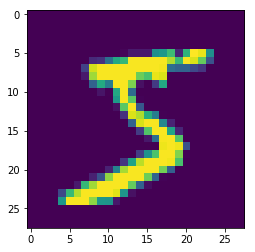

In [270]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.train_data[0])
plt.show()

In [125]:
# x = train_dataset.train_data
# x.size()

In [126]:
# train_dataset.train_data = x.view(x.size()[0], -1)

In [271]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=32)

In [273]:
train_dataset.train_data.shape

torch.Size([60000, 28, 28])

In [128]:
class Model(tc.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = tc.nn.Linear(28*28,1)
#         self.l1 = tc.nn.Linear()
#         self.l1 = tc.nn.Linear()
        self.sigmoid = tc.nn.Sigmoid()


    def forward(self, x):
        return self.sigmoid(self.l1(x))
    

model = Model()
criterion = tc.nn.BCELoss(size_average=False)
optimizer = tc.optim.SGD(model.parameters(), lr = 0.01)

In [129]:
train_loader = DataLoader(dataset=train_dataset)

for epoch in range(100):
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = Variable(inputs.view(inputs.size()[0], -1)), Variable(labels) # x.view(x.size[0], -1) flattens x matrix to one-dimensional vector.
        inputs, labels = inputs.type(tc.FloatTensor), labels.type(tc.FloatTensor)
        
        labels_predict = model(inputs)
        loss = criterion(labels_predict, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

/home/sewook/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))




Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 64 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 65 to 77 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 78 to 90 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 91 to 103 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 104 to 116 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 117 to 129 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 130 to 142 
    

In [217]:
# x = Variable(train_dataset.train_data[0].view(28, -1))
# inputs = train_dataset.train_data[0]
# inputs = Variable(inputs.view(inputs.size()[0], -1))
# x = x.type(tc.FloatTensor)
# train_dataset.train_labels[0]
# len(x)
# print(model(inputs_one))
for i in range(100):
#     print(i)
    inputs = Variable(train_dataset.train_data[i].view(-1,28*28))
    inputs = inputs.type(tc.FloatTensor)
    if model(inputs).data[0].numpy()[0] != 1:
        print(model(inputs))
# model(inputs).data[0].numpy()[0]
# test[0]
# print(train_dataset.train_data[0].view(28*28, -1))

# train_dataset.train_data[0].size()[0]

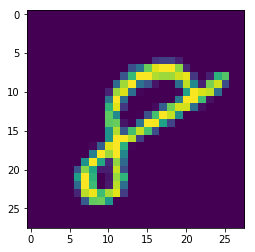

In [162]:
plt.imshow(inputs_one.view(28,28).data.numpy())
plt.show()

### 1.6.2.2 CIFAR100

In [275]:
train_dataset = datasets.CIFAR100(root='./Data/CIFAR100_Data', train=True, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


In [276]:
test_dataset = datasets.CIFAR100(root='./Data/CIFAR100_Data', train=False, transform=transforms.ToTensor())

In [277]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, num_workers=2, batch_size=32)

In [278]:
test_loader = DataLoader(dataset=test_dataset, shuffle=False, num_workers=2)

In [279]:
train_dataset.train_data.shape

(50000, 32, 32, 3)

In [280]:
class Model(tc.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = tc.nn.Linear(32*32*3, 1)
        self.sigmoid = tc.nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.linear(x))

In [281]:
model = Model()
criterion = tc.nn.BCELoss(size_average=False)
optimizer = tc.optim.SGD(model.parameters(), lr=0.01)

In [282]:
for epoch in range(100):
    for batch_idx, (data, label) in enumerate(train_loader, 0):
        data, label = Variable(data.view(data.size()[0], -1)), Variable(label)
        data, label = data.type(tc.FloatTensor), label.type(tc.FloatTensor)
#          Variable(inputs.view(inputs.size()[0], -1)), Variable(labels)
        
        label_pred = model(data)
        loss = criterion(label_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

/home/sewook/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
Process Process-28:
Process Process-27:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sewook/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sewook/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sewook/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sewook/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/sewook/anac

KeyboardInterrupt: 

  File "/usr/local/lib/python3.6/site-packages/torchvision/datasets/cifar.py", line 119, in __getitem__
    img = Image.fromarray(img)
  File "/usr/local/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 61, in __call__
    return F.to_tensor(pic)
  File "/usr/local/lib/python3.6/site-packages/torchvision/transforms/functional.py", line 75, in to_tensor
    if isinstance(img, torch.ByteTensor):
  File "/home/sewook/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2380, in fromarray
    return frombuffer(mode, size, obj, "raw", rawmode, 0, 1)
KeyboardInterrupt
  File "/home/sewook/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2333, in frombuffer
    return frombytes(mode, size, data, decoder_name, args)
  File "/home/sewook/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2266, in frombytes
    im.frombytes(data, decoder_name, args)
  File "/home/sewook/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 755, in frombytes
    s =